In [1]:
from itertools import cycle
import string
import tarfile

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from utils import gauss_smooth_fast

In [2]:
# Untar and load .mat data with single letter activities.
tar_path = 'handwritingBCIData.tar'
target_mat_path = './handwritingBCIData/Datasets/t5.2019.05.08/singleLetters.mat'

# Open the tar file
with tarfile.open(tar_path, 'r') as tar:
    # Get the file object
    mat_member = tar.getmember(target_mat_path)
    mat_file = tar.extractfile(mat_member)
    
    # Load the .mat file
    if mat_file is not None:
        data = scipy.io.loadmat(mat_file)

In [3]:
n_trials = 27 # number of trials per character
n_steps = 201 # number of time steps per trial (each step is 10ms, so 201 * 10ms * 0.001ms/s ~= 2 seconds per trial)
n_channels = 192 # number of channels (i.e. electrodes) per step

letter_key_fmt = "neuralActivityCube_{}"

In [4]:
# Display threshold crossing counts (i.e. MUA spikes) detected by the 10th electrode across all 201 time steps while writing "d".
d_activity_cube = data[letter_key_fmt.format("d")]
d_spikes = d_activity_cube[0,:,10]

assert d_activity_cube.shape == (n_trials, n_steps, n_channels)
display(d_activity_cube.shape)
display(d_spikes.shape)
display(d_spikes)

(27, 201, 192)

(201,)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1], dtype=uint8)

In [5]:
data['stdAcrossAllData'].shape

(1, 192)

In [6]:
CHARS = list(string.ascii_lowercase) + ['greaterThan','comma','apostrophe','tilde','questionMark']
letter_to_idx = {char: idx for idx, char in enumerate(CHARS)}

In [7]:
from collections import OrderedDict

# blockwise z-scored per-trial activity for each letter
letters_to_trial_raw_activity = OrderedDict()

# blockwise z-scored and smoothed per-trial activity for each letter
letters_to_trial_activity = OrderedDict()

# blockwise z-scored and smoothed trial-averaged activity for each letter
letters_to_trial_avg_activity = OrderedDict()

for idx, char in enumerate(CHARS):
    letter_activity_cube = data[letter_key_fmt.format(char)].astype(np.float64).copy()

    # Note: both sections of blockwise z-scoring code work identically.
    #get the trials that belong to this character
    trlIdx = []
    for t in range(data['characterCues'].shape[0]):
        if data['characterCues'][t,0]==char:
            trlIdx.append(t)

    #get the block that each trial belonged to
    blockIdx = data['blockNumsTimeSeries'][data['goPeriodOnsetTimeBin'][trlIdx]]
    blockIdx = np.squeeze(blockIdx)

    #subtract block-specific means from each trial 
    for b in range(data['blockList'].shape[0]):
        trialsFromThisBlock = np.squeeze(blockIdx==data['blockList'][b])
        letter_activity_cube[trialsFromThisBlock,:,:] -= data['meansPerBlock'][np.newaxis,b,:]

    #divide by standard deviation to normalize the units
    letter_activity_cube = letter_activity_cube / data['stdAcrossAllData'][np.newaxis,:,:]
    letters_to_trial_raw_activity[char] = letter_activity_cube

    # Smooth per-trial activity.
    # smoothed_activity_cube = np.zeros(shape=(n_trials, n_steps, n_channels))
    # for trial in range(n_trials):
    #     smoothed_activity_cube[trial, :, :] = gauss_smooth_fast(letter_activity_cube[trial, :, :], width=3)
    # letters_to_trial_activity[char] = smoothed_activity_cube
    letters_to_trial_activity[char] = scipy.ndimage.gaussian_filter1d(letter_activity_cube, 3.0, axis=1)

    # Compute average activity across trials, truncate from step 60 on (why?) then smooth.
    smooth_start_ts = 59
    # avg_activity = gauss_smooth_fast(np.nanmean(letter_activity_cube, axis=0)[smooth_start_ts:, :], width=5)
    avg_activity = scipy.ndimage.gaussian_filter1d(np.nanmean(letter_activity_cube, axis=0)[smooth_start_ts:, :], 5.0, axis=0)
    letters_to_trial_avg_activity[char] = avg_activity

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.33830625e-04, 4.43186162e-03, 5.39911274e-02,
       2.41971446e-01, 3.98943469e-01, 2.41971446e-01, 5.39911274e-02,
       4.56569224e-03, 4.56569224e-03, 5.39911274e-02, 2.41971446e-01,
       3.98943469e-01, 2.41971446e-01, 5.39911274e-02, 4.43186162e-03,
       1.33830625e-04, 0.00000000e+00, 1.33830625e-04, 4.43186162e-03,
       5.39911274e-02, 2.41971446e-01, 3.99077300e-01, 2.46403307e-01,
       1.08116085e-01, 2.50835169e-01, 4.53068427e-01, 4.83942891e-01,
       4.52934597e-01, 2.46403307e-01, 5.41249580e-02, 4.43186162e-03,
       1.33830625e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

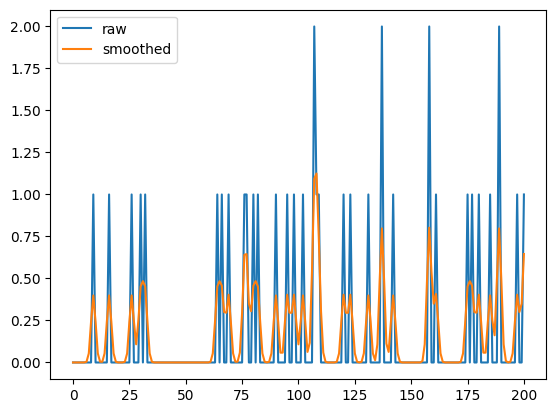

In [8]:
# Debugging: uint8 dtype messes up smoothing! Don't forget to cast as float64 on load.
ts_range = slice(0, 25)
float64_data = data[letter_key_fmt.format(char)].astype(np.float64)[0, :, 0]
uint8_data = data[letter_key_fmt.format(char)][0, ts_range, 0]

# display((float64_data, float64_data.dtype))
# display((uint8_data, uint8_data.dtype))

# display((float64_data - data["meansPerBlock"][0,0]) / data["stdAcrossAllData"][0,0])
# display((uint8_data - data["meansPerBlock"][0,0]) / data["stdAcrossAllData"][0,0])

smoothed_float64_data = scipy.ndimage.gaussian_filter1d(float64_data, 1)
# smoothed_uint8_data = scipy.ndimage.gaussian_filter1d(uint8_data, 1)
display(smoothed_float64_data)
# display(smoothed_uint8_data)

# Arrays are equal before smoothing.
# assert(np.array_equal(uint8_data, float64_data))

# # Smoothing zeroes out uint8 array, but not float64 array.
# assert(not np.array_equal(smoothed_uint8_data, smoothed_float64_data))
# assert not np.all(smoothed_float64_data == 0)
# assert np.all(smoothed_uint8_data == 0)

# Visualize smoothing.
plt.plot(float64_data, label="raw")
plt.plot(smoothed_float64_data, label="smoothed")
# plt.plot(uint8_data, label="int8")
# plt.plot(smoothed_uint8_data, label="smoothed-int8")
plt.legend()

In [9]:
letters_to_trial_activity["a"][5, 10:20, 11]
# data[letter_key_fmt.format("a")][5, 10:20, 11]

array([ 0.07791679,  0.04870469,  0.02086982, -0.00945674, -0.04128259,
       -0.06945844, -0.0873782 , -0.08933012, -0.07151954, -0.03154297])

In [12]:
from matplotlib.colors import LinearSegmentedColormap

def plot_pcs_grid(combinedPCAReduced, letterToIdx, letters, n_pcs=3, flip_scores_for_pcs=set()):
    """
    Plot a grid of PC score heatmaps across time.
    Rows = letters, Columns = PCs.

    Args:
        combinedPCAReduced: np.ndarray of shape (n_letters, n_trials, n_time_steps, n_pcs)
        letterToIdx: dict mapping letter to index in combinedPCAReduced
        letters: list of letters to plot (e.g., ['d', 'e', 'm'])
        n_pcs: number of PCs to show per letter (default 3)
    """
    n_rows = len(letters)
    n_cols = n_pcs

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), constrained_layout=True)
    axes = np.atleast_2d(axes)

    for row_idx, letter in enumerate(letters):
        letter_idx = letterToIdx[letter]
        for col_idx in range(n_pcs):
            ax = axes[row_idx, col_idx]
            pc_scores = combinedPCAReduced[letter_idx, :, :, col_idx]
            if col_idx in flip_scores_for_pcs:
                pc_scores = -pc_scores

            # 'coolwarm' / 'seismic' are good diverging colormaps
            im = ax.imshow(pc_scores, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)

            # add vertical line when "go" signal was given to start writing
            ax.axvline(x=50, color='black', linestyle='-', linewidth=1)
            ax.set_title(f"{letter.upper()} - PC{col_idx + 1}")
            ax.set_xlabel("Time steps")
            ax.set_ylabel("Trials")

            clim = np.max(np.abs(pc_scores))
            im.set_clim(-clim, clim)
            plt.colorbar(im, ax=ax, shrink=0.8)

    plt.suptitle("PCs Across Trials and Time", fontsize=16)
    plt.show()

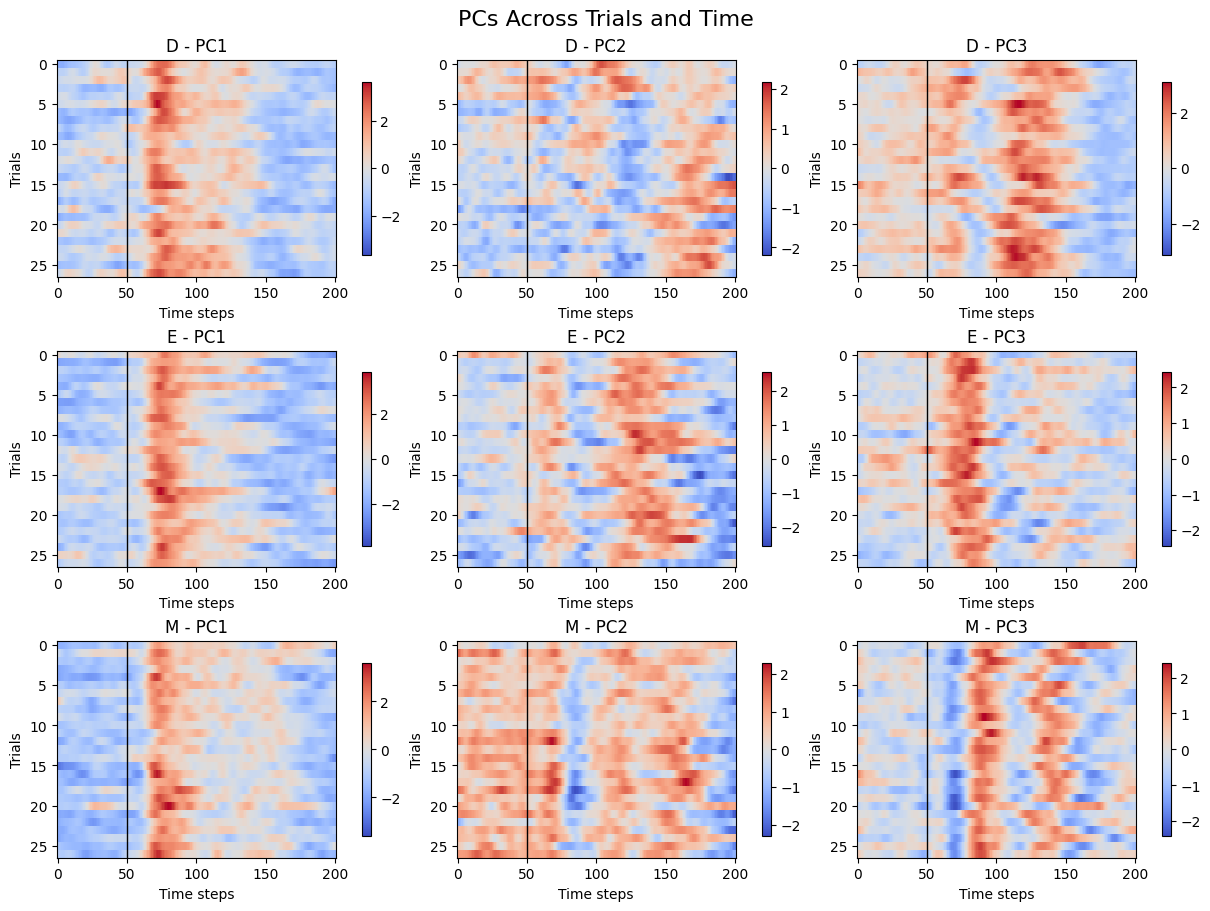

In [13]:
# fit the PCA on trial-averaged data
flattened_trial_avg_activity = np.vstack(list(letters_to_trial_avg_activity.values())).reshape(-1, n_channels)
pca_v3 = PCA(n_components=3).fit(flattened_trial_avg_activity)

# then project trial data onto PCs
flattened_trial_activity = np.vstack(list(letters_to_trial_activity.values())).reshape(-1, n_channels)
projected_v3 = pca_v3.transform(flattened_trial_activity)
# projected_v3 = normalize_pc_scores_signed(projected_v3)
projected_v3 = projected_v3.reshape(len(CHARS), n_trials, n_steps, 3)

# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
# flip to put trial 27 on top (that's what they do idk why)
plot_pcs_grid(np.flip(projected_v3, axis=1), letter_to_idx, letters=['d', 'e', 'm'], flip_scores_for_pcs={})

In [13]:
# Load time-aligned data.
# Note that this data has already been blockwise z-scored.
warped_data = scipy.io.loadmat("warped-data/_warpedCubes.mat")

In [14]:
# plt.plot(warped_data["a"][12, :, 1], label="warped")
# plt.plot(data["neuralActivityCube_a"][12, :, 1], label="raw")
# plt.legend()

In [15]:
from collections import OrderedDict

# blockwise z-scored per-trial activity for each letter
warped_letters_to_trial_raw_activity = OrderedDict()

# blockwise z-scored and smoothed per-trial activity for each letter
warped_letters_to_trial_activity = OrderedDict()

# blockwise z-scored and smoothed trial-averaged activity for each letter
warped_letters_to_trial_avg_activity = OrderedDict()

for idx, char in enumerate(CHARS):
    # Warped activity is already blockwise z-scored.
    warped_letter_activity_cube = warped_data[char].astype(np.float64).copy()
    warped_letters_to_trial_raw_activity[char] = warped_letter_activity_cube

    # Smooth per-trial activity.
    # warped_smoothed_activity_cube = np.zeros(shape=(n_trials, n_steps, n_channels))
    # for trial in range(n_trials):
    #     warped_smoothed_activity_cube[trial, :, :] = gauss_smooth_fast(warped_letter_activity_cube[trial, :, :], width=3)
    # warped_letters_to_trial_activity[char] = warped_smoothed_activity_cube
    warped_letters_to_trial_activity[char] = scipy.ndimage.gaussian_filter1d(warped_letter_activity_cube, 3.0, axis=1)

    # Compute average activity across trials, truncate from step 60 on (why?) then smooth.
    smooth_start_ts = 59
    # warped_avg_activity = gauss_smooth_fast(np.nanmean(warped_letter_activity_cube, axis=0)[smooth_start_ts:, :], width=5)
    warped_avg_activity = scipy.ndimage.gaussian_filter1d(np.nanmean(warped_letter_activity_cube, axis=0)[smooth_start_ts:, :], 5.0, axis=0)
    warped_letters_to_trial_avg_activity[char] = warped_avg_activity

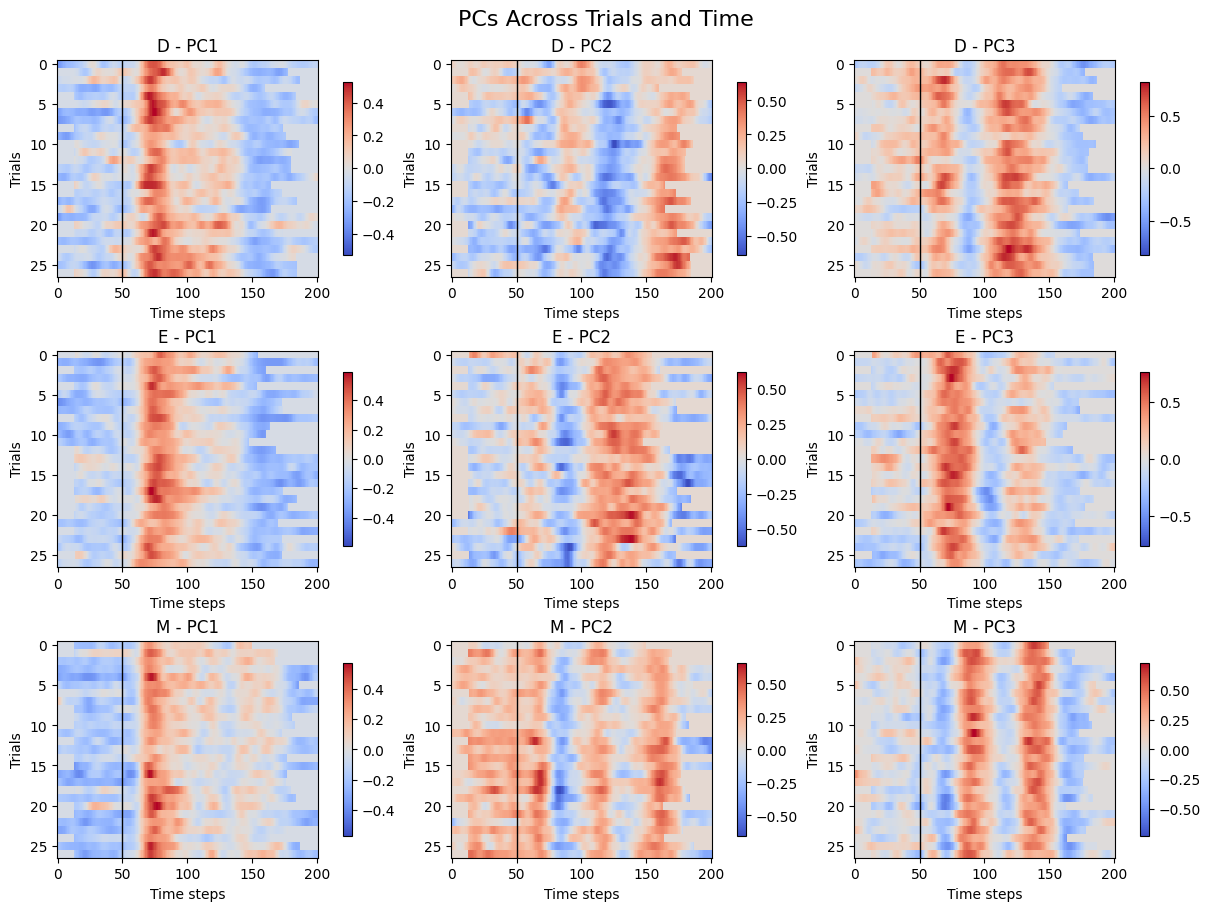

In [19]:
# fit the PCA on trial-averaged data
flattened_warped_trial_avg_activity = np.vstack(list(warped_letters_to_trial_avg_activity.values())).reshape(-1, n_channels)
warped_pca = PCA(n_components=3).fit(flattened_warped_trial_avg_activity)

# then project trial data onto PCs
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
flattened_warped_trial_activity = np.vstack(list(warped_letters_to_trial_activity.values())).reshape(-1, n_channels)
# flattened_warped_trial_activity = flattened_warped_trial_activity[~np.isnan(flattened_warped_trial_activity).any(axis=1)]
# flattened_warped_trial_activity[np.isnan(flattened_warped_trial_activity).any(axis=1)] = 0
# Impute NaNs with column means
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
flattened_warped_trial_activity_imputed = imp.fit_transform(flattened_warped_trial_activity)

from scipy.interpolate import interp1d

def interpolate_nans(arr):
    """Interpolate over NaNs along the time axis for each trial and channel."""
    for trial in range(arr.shape[0]):
        for chan in range(arr.shape[2]):
            ts = arr[trial, :, chan]
            nans = np.isnan(ts)
            if np.all(nans):  # skip if all values are NaN
                continue
            x = np.arange(len(ts))
            ts[nans] = np.interp(x[nans], x[~nans], ts[~nans])
    return arr

interpolated_data = interpolate_nans(np.vstack(list(warped_letters_to_trial_activity.values()))).reshape(-1, n_channels)

projected_warped = warped_pca.transform(flattened_warped_trial_activity_imputed)

def normalize_pc_scores_signed(pc_scores):
    """
    Normalize each PC's values to range [-1, 1], centered at 0.
    
    pc_scores: np.ndarray of shape (n_trials, n_timepoints, n_components)
    """
    scores = pc_scores.copy()
    n_components = scores.shape[-1]
    for pc in range(n_components):
        pc_vals = scores[..., pc]
        max_abs = np.nanmax(np.abs(pc_vals))
        if max_abs > 0:
            scores[..., pc] = pc_vals / max_abs
        else:
            scores[..., pc] = 0.0  # all zeros or NaNs
    return scores

projected_warped = normalize_pc_scores_signed(projected_warped)
projected_warped = projected_warped.reshape(len(CHARS), n_trials, n_steps, 3)
# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
# flip to put trial 27 on top (that's what they do idk why)
plot_pcs_grid(np.flip(projected_warped, axis=1), letter_to_idx, letters=['d', 'e', 'm'], flip_scores_for_pcs={1})

In [17]:
np.isnan(flattened_warped_trial_activity).any(axis=1).sum()

np.int64(20037)

In [ ]:
flattened_warped_trial_activity[np.isnan(flattened_warped_trial_activity).any(axis=1)]

In [ ]:
np.isnan(flattened_warped_trial_activity).any(axis=1).sum()

In [ ]:
a = flattened_warped_trial_activity = np.vstack(list(warped_letters_to_trial_activity.values())).reshape(-1, n_channels)
a[np.isnan(a).any(axis=1)] = 0

In [ ]:
# Plot the neural activity for the electrode 51 during trial 3 writing "a".
sample_trial_activity = data[letter_key_fmt.format("m")].astype(np.float64)[3, :, 51]

plt.plot(sample_trial_activity)
plt.title("Neural activity (in one electrode) while writing 'm'")
plt.xlabel("Time step")
plt.ylabel("Threshold crossing count")

In [ ]:
def figure_2_sample_activity_overlaid(letter="m"):
    """Plots neural activity, overlaid for all electrodes, for a given letter."""
    # Plot the neural activity for the electrode 51 during trial 3 writing "a".
    for e_idx in range(n_channels):
        plt.plot(data[letter_key_fmt.format("m")].astype(np.float64)[3, :, e_idx])
    
    plt.title("Neural activity in all electrodes while writing 'm'")
    plt.xlabel("Time step")
    plt.ylabel("Threshold crossing count")

figure_2_sample_activity_overlaid()

In [ ]:
def figure_3_sample_activity_split_up(letter="m"):
    """Plots neural activity across a few electrodes for a given letter."""
    # Get the sample trial activity for trial 3 writing "m"
    sample_trial = data[letter_key_fmt.format("m")].astype(np.float64)[3]
    n_time_steps = sample_trial.shape[0]

    # Update number of pre-ellipsis channels
    n_channels_before_ellipsis = 5

    # Set up figure with enough subplots (5 channels + 1 ellipsis + 1 final channel)
    fig, axs = plt.subplots(n_channels_before_ellipsis + 2, 1, figsize=(12, 8), sharex=True,
                            gridspec_kw={'height_ratios': [1]*n_channels_before_ellipsis + [0.3, 1]})

    # Color cycle
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    # Plot first 5 channels
    for i in range(n_channels_before_ellipsis):
        color = next(color_cycle)
        axs[i].plot(sample_trial[:, i], color=color)
        axs[i].set_ylabel(f"Chan {i}")

    # Ellipsis
    axs[n_channels_before_ellipsis].set_xlim(0, n_time_steps - 1)
    axs[n_channels_before_ellipsis].text(n_time_steps / 2, 0.5, "...", ha='center', va='center', fontsize=16)
    axs[n_channels_before_ellipsis].axis('off')
    
    # Last channel (191)
    color = next(color_cycle)
    axs[-1].plot(sample_trial[:, 191], color=color)
    axs[-1].set_ylabel("Chan 191")
    axs[-1].set_xlabel("Time step")
    axs[-1].set_title("Channel 191")

    # Final formatting
    plt.suptitle("Neural activity (sample channels) while writing 'm'", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

figure_3_sample_activity_split_up()

In [ ]:
# [Figure] Standard Deviations of Firing Rate Varies across Electrodes
def figure_std_dev_firing_rates_vary_across_electrodes():
    plt.hist(data["stdAcrossAllData"].squeeze(), bins=50)
    plt.show()

figure_std_dev_firing_rates_vary_across_electrodes()

In [ ]:
# [Figure] Mean Firing Rate Drifts over Time.
def figure_baseline_firing_rate_drifts():
    # (9, 192)
    block_means = data['meansPerBlock'] - np.mean(data['meansPerBlock'], axis=0)
    plt.scatter(np.arange(block_means.shape[0]), block_means[:, 0])
    plt.show()

figure_baseline_firing_rate_drifts()

In [ ]:
display(data['meansPerBlock'].shape)
np.array_equal(np.std(data['meansPerBlock'], axis=0), np.std(data['meansPerBlock'] - np.mean(data['meansPerBlock'], axis=0), axis=0))

In [ ]:
# [Figure] Mean Firing Rate Drifts over Time.
def figure_baseline_firing_rate_drifts():
    block_means = data['meansPerBlock'] - np.mean(data['meansPerBlock'], axis=0)
    electrode_std_devs = np.std(block_means, axis=0)

    z_scored_means = block_means / electrode_std_devs
    plt.imshow(data['meansPerBlock'])
    plt.xlabel("Electrode #")
    plt.ylabel("Block #")
    plt.show()

figure_baseline_firing_rate_drifts()

In [ ]:
def subtract_blockwise_mean(data, letter_activity_cube):
    #get the trials that belong to this character
    trlIdx = []
    for t in range(data['characterCues'].shape[0]):
        if data['characterCues'][t,0]==char:
            trlIdx.append(t)

    #get the block that each trial belonged to
    blockIdx = data['blockNumsTimeSeries'][data['goPeriodOnsetTimeBin'][trlIdx]]
    blockIdx = np.squeeze(blockIdx)

    #subtract block-specific means from each trial 
    for b in range(data['blockList'].shape[0]):
        trialsFromThisBlock = np.squeeze(blockIdx==data['blockList'][b])
        letter_activity_cube[trialsFromThisBlock,:,:] -= data['meansPerBlock'][np.newaxis,b,:]
    return letter_activity_cube

def figure_before_and_after_z_score(letter="a", trial_idx=10):
    # sort by std. dev.
    std_dev_sort_idx = data['stdAcrossAllData'].squeeze().argsort()

    # (n_steps, n_channels)
    letter_activity_cube = data[letter_key_fmt.format(letter)].astype(np.float64)
    detrended_activity_cube = subtract_blockwise_mean(data, letter_activity_cube.copy())
    z_scored_activity_cube = detrended_activity_cube / data['stdAcrossAllData'][np.newaxis,:,:]

    # Plot before and after normalization
    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    im1 = axs[0].imshow(letter_activity_cube[trial_idx, :, std_dev_sort_idx].T, aspect='auto', cmap='viridis')
    axs[0].set_title("Raw Firing Rates Across Electrodes")
    axs[0].set_ylabel("Electrodes")
    plt.colorbar(im1, ax=axs[0], orientation='vertical', label="Firing Rate")
    
    im2 = axs[1].imshow(detrended_activity_cube[trial_idx, :, std_dev_sort_idx].T, aspect='auto', cmap='viridis', vmin=-2.5, vmax=2.5)
    axs[1].set_title("Detrended (subtract mean) Firing Rates")
    axs[1].set_ylabel("Electrodes")
    axs[1].set_xlabel("Time Steps")
    plt.colorbar(im2, ax=axs[1], orientation='vertical', label="Dentrended Firing Rate")

    im3 = axs[2].imshow(z_scored_activity_cube[trial_idx, :, std_dev_sort_idx].T, aspect='auto', cmap='viridis', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Z-scored (Normalized) Firing Rates")
    axs[2].set_ylabel("Electrodes")
    axs[2].set_xlabel("Time Steps")
    plt.colorbar(im3, ax=axs[2], orientation='vertical', label="Z-scored Firing Rate")

    plt.tight_layout()
    plt.show()

figure_before_and_after_z_score()

In [ ]:
def figure_mean_firing_rates_across_trials(letter="m"):
    activity_cube = data[letter_key_fmt.format(letter)].astype(np.float64) / data['stdAcrossAllData'][np.newaxis,:,:] # shape (trials, time_steps, channels)

    # Compute mean firing rate for each electrode in each trial
    mean_raw = np.mean(activity_cube, axis=1).T  # shape (channels, trials)

    # Apply detrending and compute means again
    detrended = apply_blockwise_z_score(data, activity_cube.copy())
    mean_detrended = np.mean(detrended, axis=1).T

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    im1 = axs[0].imshow(mean_raw, aspect='auto', cmap='viridis')
    axs[0].set_title("Raw Mean Firing Rate per Trial")
    axs[0].set_xlabel("Trial #")
    axs[0].set_ylabel("Electrode #")
    plt.colorbar(im1, ax=axs[0], label="Mean Firing Rate")

    im2 = axs[1].imshow(mean_detrended, aspect='auto', cmap='viridis', vmin=-2.5, vmax=2.5)
    axs[1].set_title("After Blockwise Mean Subtraction")
    axs[1].set_xlabel("Trial #")
    plt.colorbar(im2, ax=axs[1], label="Detrended Mean Firing Rate")

    plt.tight_layout()
    plt.show()

# Interpretation:
# - vertical Stripes indicate electrodes with stable firing rates across trials
# - changes horizontal wise indicate baseline changes in mean firing rates
figure_mean_firing_rates_across_trials()

In [ ]:
data['meansPerBlock'].shape